#Clustering

##K-Means

In [1]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [2]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.447s	69662	0.680	0.719	0.699	0.570	0.695	0.180
random   	0.362s	69707	0.675	0.716	0.694	0.560	0.691	0.184
PCA-based	0.279s	72686	0.636	0.658	0.647	0.521	0.643	0.144
__________________________________________________________________________________


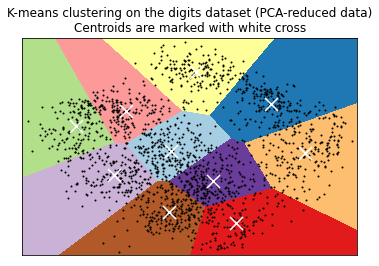

In [4]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

##Affinity Propagation

Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


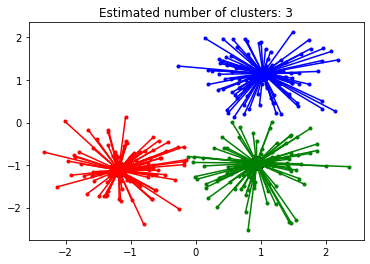

In [6]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=300, centers=centers, cluster_std=0.5, random_state=0
)

# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50, random_state=0).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X, labels, metric="sqeuclidean")
)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close("all")
plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

##Mean_Shift

number of estimated clusters : 3


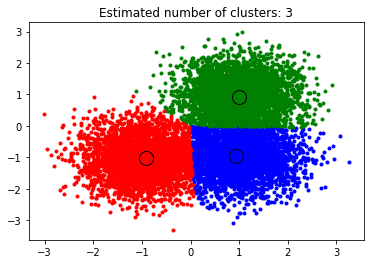

In [7]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

##Spectral CLastering

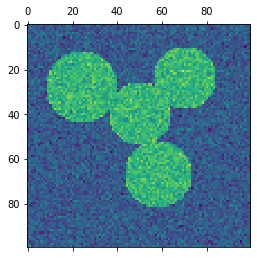

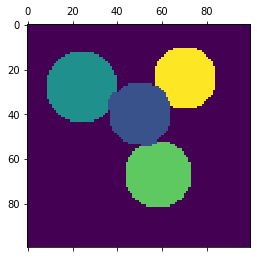

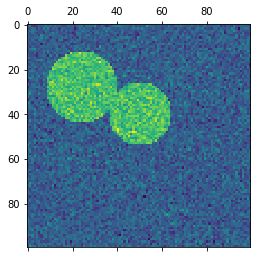

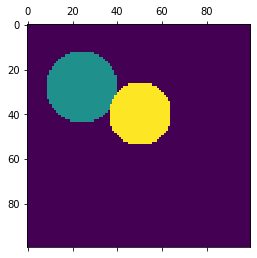

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

# #############################################################################
# 4 circles
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

# #############################################################################
# 2 circles
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=2, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

plt.show()

##Hierarchical clustering

In [10]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice



In [11]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

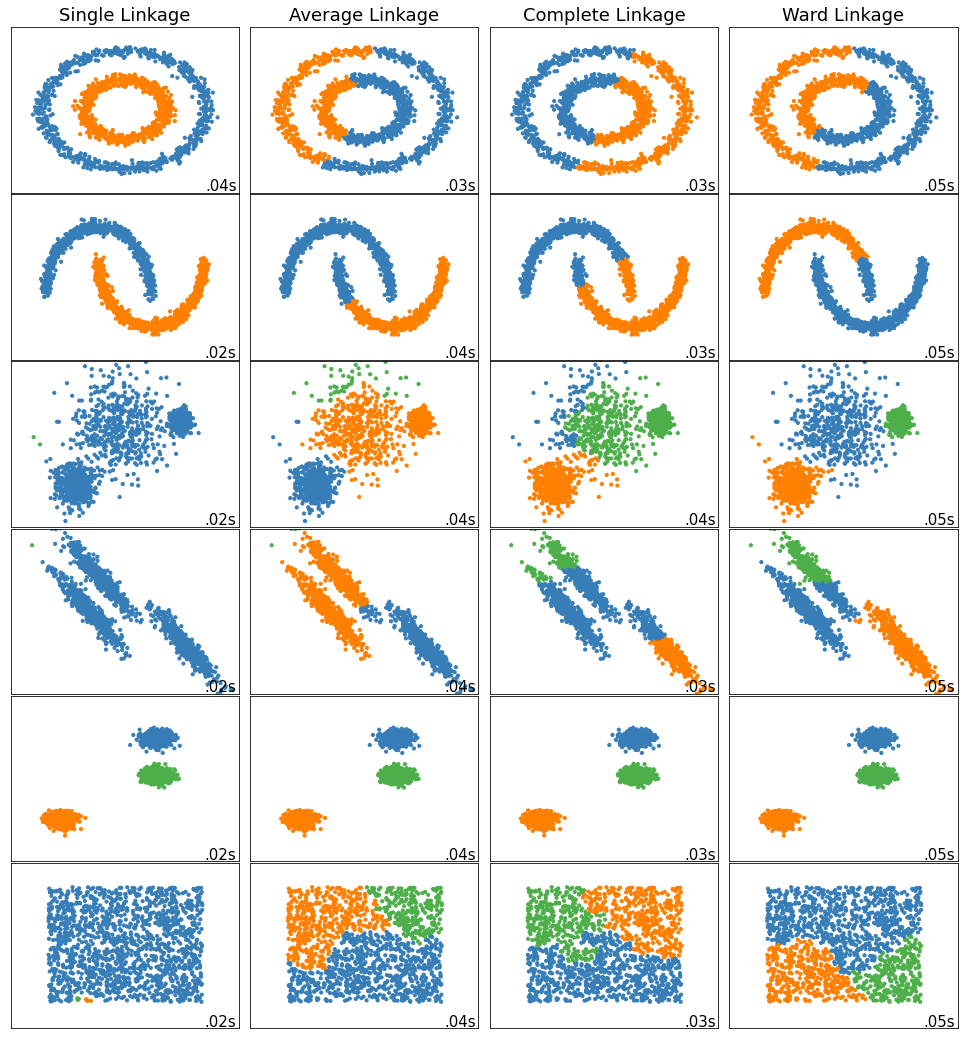

In [13]:

plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {"n_neighbors": 10, "n_clusters": 3}

datasets = [
    (noisy_circles, {"n_clusters": 2}),
    (noisy_moons, {"n_clusters": 2}),
    (varied, {"n_neighbors": 2}),
    (aniso, {"n_neighbors": 2}),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward"
    )
    complete = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="complete"
    )
    average = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="average"
    )
    single = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="single"
    )

    clustering_algorithms = (
        ("Single Linkage", single),
        ("Average Linkage", average),
        ("Complete Linkage", complete),
        ("Ward Linkage", ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()